# Spring 2018 TR-GY 7133 Assignment 4: Transit Network Design

## Author: Yuwen Chang (NYU CUSP 2018)

## Coded in Python 3

## To modify the results, go through each CHECKPOINT and overwrite existing settings

# 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sympy as sp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set parameters
v_walk = 3 # walk speed (mph)
v_bus = 10 # bus speed (mph)
alpha = 0.5 # headway reliability
beta = -7 # elasticity
threshold = 0.5 # acceptable access distance (mile)
budget = 10 # operation budget (veh * hr)
freq_min = 1 # minimum freq for each zone (veh / hr)

# 1. Stops Allocation and Route Determination

In [3]:
# read data
df = pd.read_csv("ODpair.csv", index_col=0)
df

,O-x,O-y,D-x,D-y,K
1,3.990,1.978,4.848,2.582,500
2,0.624,3.954,3.706,3.508,500
3,2.841,0.927,4.776,4.150,500
4,0.452,2.411,4.963,3.474,500
5,1.262,2.485,0.659,0.962,500
6,0.564,4.598,4.409,4.956,250
7,0.697,3.301,2.362,1.704,250
8,1.502,4.521,0.972,0.117,250
9,0.173,3.789,3.827,2.882,250
10,4.728,4.073,2.238,0.374,250


In [4]:
# generate separate dfs for Origin and Destination zones
O = df[['O-x', 'O-y', 'K']]
D = df[['D-x', 'D-y', 'K']]

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/text.py:2108: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


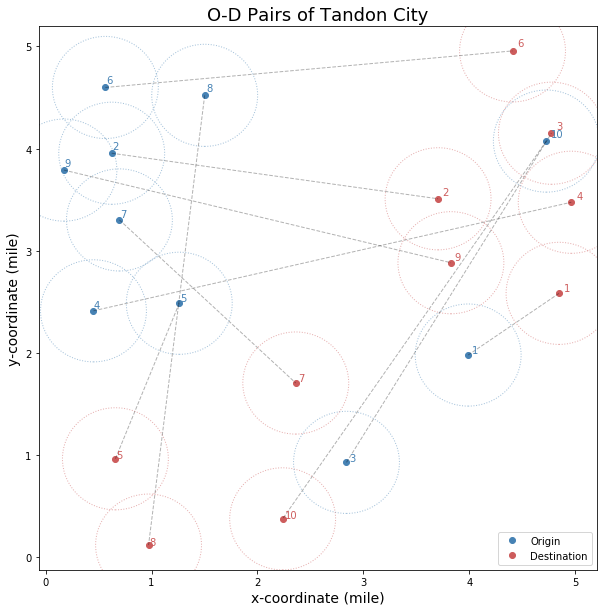

In [5]:
# plot all zones, O-D pairs, and accessible range
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df['O-x'], df['O-y'], 'o', color='steelblue', label='Origin')
ax.plot(df['D-x'], df['D-y'], 'o', color='indianred', label='Destination')

for i in range(1,len(df)+1):
    access_O = plt.Circle((df['O-x'][i], df['O-y'][i]), threshold, ls=':', color='steelblue', fill=False, alpha=0.5)
    access_D = plt.Circle((df['D-x'][i], df['D-y'][i]), threshold, ls=':', color='indianred', fill=False, alpha=0.5)
    ax.annotate(i, [df['O-x'][i], df['O-y'][i]], textcoords='offset points', color='steelblue')
    ax.annotate(i, [df['D-x'][i], df['D-y'][i]], textcoords='offset points', color='indianred')
    ax.plot([df['O-x'][i], df['D-x'][i]], [df['O-y'][i], df['D-y'][i]], 'k--', linewidth=1, alpha=0.3)
    ax.add_artist(access_O)
    ax.add_artist(access_D)

plt.xlabel('x-coordinate (mile)', fontsize=14)
plt.ylabel('y-coordinate (mile)', fontsize=14)
plt.title('O-D Pairs of Tandon City', fontsize=18)

plt.legend(loc='lower right')
plt.savefig('fig1.png', dpi=300)
plt.show()

In [6]:
# define tool functions
def midpoint(points):
    """
    Calculate the midpoint of a list of points,
    or return the coordinate of a single point.
    """
    coords = []
    for p in points:
        if p[0] == 'O':
            coords.append(O.iloc[int(p[1:])-1,:2])
        else:
            coords.append(D.iloc[int(p[1:])-1,:2])
    return np.array(coords).mean(axis=0)

def nearest(points):
    """
    Find the nearest point on a circle to a line.
    INPUT three points as a list:
    - the first two determine the line function
    - the third determines the circle with r = threshold
    """
    coords = np.array(points)
    xc = coords[2][0] # centroid x-coord of circle
    yc = coords[2][1] # centroid y-coord of circle

    diff = coords[1] - coords[0]
    a = - diff[0] / diff[1] # slope of the perpendicular line function
    b = yc - a * xc     # intercept of the perpendicular line function

    # solve equation (two solutions: farest and nearest)
    x = sp.symbols('x')
    sol_x = sp.solve((x - xc) ** 2 + (a * x + b - yc) ** 2 - threshold ** 2, x)
    
    y0 = a * sol_x[0] + b # solution coordinate 1
    y1 = a * sol_x[1] + b # solution coordinate 2
    
    # determine which of the two solutions is the nearer one
    dist0 = (sol_x[0] - coords[0][0]) ** 2 + (y0 - coords[0][1]) ** 2
    dist1 = (sol_x[1] - coords[0][0]) ** 2 + (y1 - coords[0][1]) ** 2
    
    if dist0 < dist1:
        return numpy.float64([sol_x[0], y0])
    else:
        return numpy.float64([sol_x[1], y1])

In [7]:
# determine stops covering several zones
stop1 = midpoint(['O6', 'O8'])
stop2 = midpoint(['O2', 'O7', 'O9'])
stop3 = midpoint(['O4', 'O5'])
stop4 = midpoint(['D5', 'D8'])
stop6 = midpoint(['O3', 'D7'])
stop7 = midpoint(['O1', 'D9'])
stop8 = midpoint(['D1', 'D4'])
stop10 = midpoint(['O10', 'D6'])

# determine detours of the skeletal route
# in order to cover a single zone
stop5 = nearest([stop4, stop6, midpoint(['D10'])])
stop9 = nearest([stop8, stop10, midpoint(['D2'])])

# generate list of stops
stops = np.array([stop1, stop2, stop3, stop4, stop5, stop6, stop7, stop8, stop9, stop10, stop1]).T
stops

array([[1.033     , 0.498     , 0.857     , 0.8155    , 2.03874962,
        2.6015    , 3.9085    , 4.9055    , 4.19362597, 4.5685    ,
        1.033     ],
       [4.5595    , 3.68133333, 2.448     , 0.5395    , 0.832584  ,
        1.3155    , 2.43      , 3.028     , 3.61854824, 4.5145    ,
        4.5595    ]])

## >>> CHECKPOINT 1: Stops Generation
To test different output, modify stops here!

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/text.py:2108: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


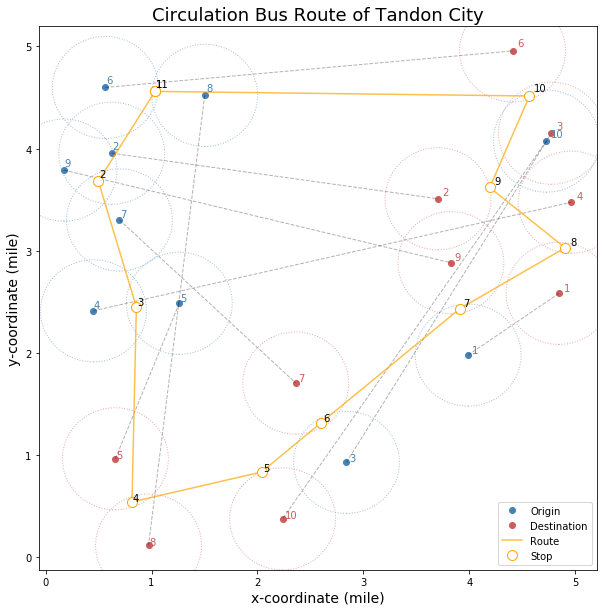

In [8]:
# plot proposed route and stops
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df['O-x'], df['O-y'], 'o', color='steelblue', label='Origin')
ax.plot(df['D-x'], df['D-y'], 'o', color='indianred', label='Destination')

for i in range(1,len(df)+1):
    access_O = plt.Circle((df['O-x'][i], df['O-y'][i]), threshold, ls=':', color='steelblue', fill=False, alpha=0.5)
    access_D = plt.Circle((df['D-x'][i], df['D-y'][i]), threshold, ls=':', color='indianred', fill=False, alpha=0.5)
    ax.annotate(i, [df['O-x'][i], df['O-y'][i]], textcoords='offset points', color='steelblue')
    ax.annotate(i, [df['D-x'][i], df['D-y'][i]], textcoords='offset points', color='indianred')
    ax.plot([df['O-x'][i], df['D-x'][i]], [df['O-y'][i], df['D-y'][i]], 'k--', linewidth=1, alpha=0.3)
    ax.add_artist(access_O)
    ax.add_artist(access_D)

ax.plot(stops[0], stops[1], '-', color='orange', alpha=0.7, label='Route')
ax.plot(stops[0], stops[1], 'o', markerfacecolor='white', markeredgecolor='orange', markersize=10, label='Stop')
[ax.annotate(i+1, [stops[0][i], stops[1][i]],
             textcoords='offset points', color='black') for i in range(len(stops[0]))]

plt.xlabel('x-coordinate (mile)', fontsize=14)
plt.ylabel('y-coordinate (mile)', fontsize=14)
plt.title('Circulation Bus Route of Tandon City', fontsize=18)

plt.legend(loc='lower right')
plt.savefig('fig2.png', dpi=300)
plt.show()

# 2. Cost and Demand Calculations

In [9]:
# generate a df of stops
stops_df = pd.DataFrame(stops.T)
stops_df.columns = ['x', 'y']

In [10]:
# generate a df of coordinate differences
diff_df = stops_df.diff()
diff_df.drop(0, axis=0, inplace=True)
diff_df.columns = ['dx', 'dy']

# calculate segment lengths
diff_df['diff'] = np.sqrt(diff_df['dx']**2 + diff_df['dy']**2)
RT_length = diff_df['diff'].sum()
print("Total Route Length: ", RT_length, " miles")

# calculate distance along route for both directions
diff_df['dist_ACW'] = diff_df['diff'].cumsum()
diff_df['dist_CW'] = list(reversed(list(diff_df['dist_ACW'])))
diff_df

Total Route Length:  14.533382622757879  miles


,dx,dy,diff,dist_ACW,dist_CW
1,-0.535000,-0.878167,1.028300,1.028300,14.533383
2,0.359000,-1.233333,1.284520,2.312821,10.997596
3,-0.041500,-1.908500,1.908951,4.221772,10.026380
4,1.223250,0.293084,1.257870,5.479642,9.101442
5,0.562750,0.482916,0.741550,6.221192,7.938853
6,1.307000,1.114500,1.717661,7.938853,6.221192
7,0.997000,0.598000,1.162589,9.101442,5.479642
8,-0.711874,0.590548,0.924939,10.026380,4.221772
9,0.374874,0.895952,0.971216,10.997596,2.312821
10,-3.535500,0.045000,3.535786,14.533383,1.028300


In [11]:
# append "distance along route" back to stops df
tmp = [0]
[tmp.append(i) for i in list(diff_df['dist_ACW'])]
stops_df['dist_ACW'] = tmp
tmp = list(diff_df['dist_CW'])
tmp.append(0)
stops_df['dist_CW'] = tmp
stops_df

,x,y,dist_ACW,dist_CW
0,1.033000,4.559500,0.000000,14.533383
1,0.498000,3.681333,1.028300,10.997596
2,0.857000,2.448000,2.312821,10.026380
3,0.815500,0.539500,4.221772,9.101442
4,2.038750,0.832584,5.479642,7.938853
5,2.601500,1.315500,6.221192,6.221192
6,3.908500,2.430000,7.938853,5.479642
7,4.905500,3.028000,9.101442,4.221772
8,4.193626,3.618548,10.026380,2.312821
9,4.568500,4.514500,10.997596,1.028300


In [12]:
# define tool functions
def ride_dist(o, d, direction='ACW'):
    """
    Calculate ride distance from O to D.
    specify direction with 'ACW' or 'CW'
    """
    if direction == 'ACW':
        dist = stops_df['dist_ACW'][d-1] - stops_df['dist_ACW'][o-1]
    else:
        dist = stops_df['dist_ACW'][o-1] - stops_df['dist_ACW'][d-1]

    return (dist + RT_length) % RT_length # use remainder to make the route as a loop

def walk_dist(c, s):
    """
    Calculate walk distance from Centroid to Stop.
    """
    if c[0] == 'O':
        c_coord = np.array(O.iloc[int(c[1:])-1,:2])
    else:
        c_coord = np.array(D.iloc[int(c[1:])-1,:2])
    
    s_coord = np.array(stops_df.iloc[s-1,:2])
    
    dist = np.sqrt((s_coord[0] - c_coord[0]) ** 2 + (s_coord[1] - c_coord[1]) ** 2)
    return dist

In [13]:
# input desired stops for each O-D zone
df['O-stop'] = [7, 2, 6, 3, 3, 1, 2, 1, 2, 10]
df['D-stop'] = [8, 9, 10, 8, 4, 10, 6, 4, 7, 5]
df

,O-x,O-y,D-x,D-y,K,O-stop,D-stop
1,3.990,1.978,4.848,2.582,500,7,8
2,0.624,3.954,3.706,3.508,500,2,9
3,2.841,0.927,4.776,4.150,500,6,10
4,0.452,2.411,4.963,3.474,500,3,8
5,1.262,2.485,0.659,0.962,500,3,4
6,0.564,4.598,4.409,4.956,250,1,10
7,0.697,3.301,2.362,1.704,250,2,6
8,1.502,4.521,0.972,0.117,250,1,4
9,0.173,3.789,3.827,2.882,250,2,7
10,4.728,4.073,2.238,0.374,250,10,5


## >>> CHECKPOINT 2: Stops Assignment
To test different output, modify stops here!

In [14]:
# calculate distances (ride/travel and walk/access)
tmp1 = []
tmp2 = []
tmp3 = []
tmp4 = []

for i in range(1,len(df)+1):
    tmp1.append(ride_dist(df['O-stop'][i], df['D-stop'][i], 'ACW'))
    tmp2.append(ride_dist(df['O-stop'][i], df['D-stop'][i], 'CW'))
    tmp3.append(walk_dist('O%s'%(i), df['O-stop'][i]))
    tmp4.append(walk_dist('D%s'%(i), df['D-stop'][i]))

df['dist_ACW'] = tmp1
df['dist_CW'] = tmp2
df['dist_O'] = tmp3
df['dist_D'] = tmp4
df

,O-x,O-y,D-x,D-y,K,O-stop,D-stop,dist_ACW,dist_CW,dist_O,dist_D
1,3.990,1.978,4.848,2.582,500,7,8,1.162589,13.370794,0.459289,0.449691
2,0.624,3.954,3.706,3.508,500,2,9,8.998080,5.535303,0.300372,0.500000
3,2.841,0.927,4.776,4.150,500,6,10,4.776405,9.756978,0.456391,0.419424
4,0.452,2.411,4.963,3.474,500,3,8,6.788621,7.744762,0.406687,0.449691
5,1.262,2.485,0.659,0.962,500,3,4,1.908951,12.624431,0.406687,0.450554
6,0.564,4.598,4.409,4.956,250,1,10,10.997596,3.535786,0.470578,0.469428
7,0.697,3.301,2.362,1.704,250,2,6,5.192891,9.340491,0.429249,0.456391
8,1.502,4.521,0.972,0.117,250,1,4,4.221772,10.311611,0.470578,0.450554
9,0.173,3.789,3.827,2.882,250,2,7,6.910552,7.622830,0.342370,0.459289
10,4.728,4.073,2.238,0.374,250,10,5,9.015428,5.517954,0.469428,0.500000


In [15]:
# calculate frequency
RT_time = RT_length / v_bus
max_veh = budget // RT_time
freq_a = 6 / RT_time # anti-clockwise
freq_b = 0 / RT_time # clockwise
freq_total = freq_a + freq_b
prob_a = freq_a / freq_total
prob_b = freq_b / freq_total
print("Max Fleet Size, RT Length, Frequencies(a, b), Probablilities(a, b)")
max_veh, RT_length, freq_a, freq_b, prob_a, prob_b

Max Fleet Size, RT Length, Frequencies(a, b), Probablilities(a, b)


(6.0, 14.533382622757879, 4.128426365521112, 0.0, 1.0, 0.0)

## >>> CHECKPOINT 3: Frequency Determination
To test different output, modify the frequency here!

In [16]:
# calculate costs and demand for one-way route
df['cost_ACW'] = df['dist_ACW'] / v_bus
df['cost_CW'] = df['dist_CW'] / v_bus
df['cost_walk'] = (df['dist_O'] + df['dist_D']) / v_walk
df['cost_wait'] = alpha / (freq_a + freq_b)
df['Cij_ACW'] = df['cost_walk'] + df['cost_wait'] + df['cost_ACW']
df['Cij_CW'] = df['cost_walk'] + df['cost_wait'] + df['cost_CW']
df['Dij_ACW'] = df['K'] * exp(beta * df['Cij_ACW'])
df['Dij_CW'] = df['K'] * exp(beta * df['Cij_CW'])

# calculate costs and demand for two-way route
df['cost_TwoWay'] = prob_a * df['cost_ACW'] + prob_b * df['cost_CW']
df['Cij_TwoWay'] = df['cost_walk'] + df['cost_wait'] + df['cost_TwoWay']
df['Dij_TwoWay'] = df['K'] * exp(beta * df['Cij_TwoWay'])
df

,O-x,O-y,D-x,D-y,K,O-stop,D-stop,dist_ACW,dist_CW,dist_O,...,cost_CW,cost_walk,cost_wait,Cij_ACW,Cij_CW,Dij_ACW,Dij_CW,cost_TwoWay,Cij_TwoWay,Dij_TwoWay
1,3.990,1.978,4.848,2.582,500,7,8,1.162589,13.370794,0.459289,...,1.337079,0.302993,0.121112,0.540364,1.761184,11.382323,0.002212,0.116259,0.540364,11.382323
2,0.624,3.954,3.706,3.508,500,2,9,8.998080,5.535303,0.300372,...,0.553530,0.266791,0.121112,1.287710,0.941432,0.060849,0.687002,0.899808,1.287710,0.060849
3,2.841,0.927,4.776,4.150,500,6,10,4.776405,9.756978,0.456391,...,0.975698,0.291938,0.121112,0.890690,1.388748,0.979980,0.029998,0.477640,0.890690,0.979980
4,0.452,2.411,4.963,3.474,500,3,8,6.788621,7.744762,0.406687,...,0.774476,0.285459,0.121112,1.085433,1.181047,0.250719,0.128385,0.678862,1.085433,0.250719
5,1.262,2.485,0.659,0.962,500,3,4,1.908951,12.624431,0.406687,...,1.262443,0.285747,0.121112,0.597753,1.669301,7.616634,0.004209,0.190895,0.597753,7.616634
6,0.564,4.598,4.409,4.956,250,1,10,10.997596,3.535786,0.470578,...,0.353579,0.313335,0.121112,1.534206,0.788025,0.005418,1.005298,1.099760,1.534206,0.005418
7,0.697,3.301,2.362,1.704,250,2,6,5.192891,9.340491,0.429249,...,0.934049,0.295213,0.121112,0.935614,1.350374,0.357780,0.019621,0.519289,0.935614,0.357780
8,1.502,4.521,0.972,0.117,250,1,4,4.221772,10.311611,0.470578,...,1.031161,0.307044,0.121112,0.850332,1.459316,0.649946,0.009152,0.422177,0.850332,0.649946
9,0.173,3.789,3.827,2.882,250,2,7,6.910552,7.622830,0.342370,...,0.762283,0.267220,0.121112,1.079386,1.150614,0.130779,0.079433,0.691055,1.079386,0.130779
10,4.728,4.073,2.238,0.374,250,10,5,9.015428,5.517954,0.469428,...,0.551795,0.323143,0.121112,1.345797,0.996050,0.020260,0.234363,0.901543,1.345797,0.020260


# 3. Results

In [17]:
def distribute(a, b, alpha=0.5):
    """
    Distribute number of vehicles between directions.
    Current limit is 6 buses at max.
    a: anti-clockwise # of vehicles
    b: clockwise # of vehicles
    """
    # calculate frequency
    RT_time = RT_length / v_bus
    freq_a = a / RT_time # anti-clockwise
    freq_b = b / RT_time # clockwise
    freq_total = freq_a + freq_b
    prob_a = freq_a / freq_total
    prob_b = freq_b / freq_total

    # calculate costs and demand for one-way route
    df['cost_ACW'] = df['dist_ACW'] / v_bus
    df['cost_CW'] = df['dist_CW'] / v_bus
    df['cost_walk'] = (df['dist_O'] + df['dist_D']) / v_walk
    df['cost_wait'] = alpha / (freq_a + freq_b)
    df['Cij_ACW'] = df['cost_walk'] + df['cost_wait'] + df['cost_ACW']
    df['Cij_CW'] = df['cost_walk'] + df['cost_wait'] + df['cost_CW']
    df['Dij_ACW'] = df['K'] * exp(beta * df['Cij_ACW'])
    df['Dij_CW'] = df['K'] * exp(beta * df['Cij_CW'])

    # calculate costs and demand for two-way route
    df['cost_TwoWay'] = prob_a * df['cost_ACW'] + prob_b * df['cost_CW']
    df['Cij_TwoWay'] = df['cost_walk'] + df['cost_wait'] + df['cost_TwoWay']
    df['Dij_TwoWay'] = df['K'] * exp(beta * df['Cij_TwoWay'])
    
    print("Total Demand:", df['Dij_TwoWay'].sum(), "per hour")

In [18]:
distribute(6, 0)

Total Demand: 21.454689116779374 per hour


In [19]:
distribute(3, 3)

Total Demand: 1.2986117961787833 per hour


In [20]:
distribute(0, 6)

Total Demand: 2.1996735120467257 per hour


In [21]:
distribute(6, 0, 0.75)

Total Demand: 14.042000887928081 per hour


In [22]:
# save tables
stops_df.to_csv("tab1.csv")
df.to_csv("tab2.csv")